In [1]:
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.pipeline
import sklearn.datasets
import sklearn.metrics
import matplotlib.pyplot as plt
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

## 4.5 线性模型的正则化
正如我们在第一和第二章看到的那样，降低模型的过拟合的好方法是正则化这个模型(即限制它)：模型有越少的自由度，就越难以拟合数据。例如，正则化一个多项式模型，一个简单的方法就是减少多项式的阶数。

对于一个线性模型，正则化的典型实现就是约束模型中参数的权重。 接下来我们将介绍三种不同约束权重的方法：`Ridge`回归、`Lasso`回归和`Elastic Net`。

### 4.5.1 岭(Ridge)回归
岭回归(也称为Tikhonov正则化)是线性回归的正则化版：在损失函数上直接加上一个正则项$\alpha\sum_{i=1}^n\theta_i^2$。这使得学习算法不仅能够拟合数据，而且能够使模型的参数权重尽量的小。注意到这个正则项只有在训练过程中才会被加到损失函数。当得到完成训练的模型后，我们应该使用没有正则化的测量方法去评价模型的表现。

> **提示**
> 
> 一般情况下，训练过程使用的损失函数和测试过程使用的评价函数是不一样的。除了正则化，还有一个不同：训练时的损失函数应该在优化过程中易于求导，而在测试过程中，评价函数更应该接近最后的客观表现。一个好的例子：在分类训练中我们使用对数损失(马上我们会讨论它)作为损失函数，但是我们却使用精确率/召回率来作为它的评价函数

超参数$\alpha$决定了你想正则化这个模型的强度。如果$\alpha=0$，那么此时的岭回归便变为了线性回归。如果$\alpha$非常的大，所有的权重最后都接近于零，最后结果将是一条穿过数据平均值的水平直线。`公式4-8`是岭回归的损失函数：
+ $J(\theta)=MSE(\theta)+\alpha\frac{1}{2}\sum\limits_{i=1}^n\theta_i^2$

值得注意的是偏差$\theta_0$是没有被正则化的(累加运算的开始是$i=1$而不是$i=0$)。如我定义$\mathbf{w}$作为特征的权重向量($\theta_1$到$\theta_n$)，那么正则项可以简写成$\frac{1}{2}{({\parallel \mathbf{w}\parallel_2})}^2$，其中$\parallel \cdot \parallel_2$表示权重向量的$\ell_2$范数。对于梯度下降来说仅仅在均方差梯度向量(`公式4-6`)加上一项$\alpha\mathbf{w}$。

> **提示**
> 
> 在使用岭回归前，对数据进行放缩(可以使用`StandardScaler`)是非常重要的，算法对于输入特征的数值尺度(scale)非常敏感。大多数的正则化模型都是这样的

`图4-17`展示了在相同线性数据上使用不同$\alpha$值的岭回归模型最后的表现。左图中，使用简单的岭回归模型，最后得到了线性的预测。右图中的数据首先使用10阶的`PolynomialFearures`进行扩展，然后使用`StandardScaler`进行缩放，最后将岭模型应用在处理过后的特征上。这就是带有岭正则项的多项式回归。注意当$\alpha$增大的时候，导致预测曲线变得扁平(即少了极端值，多了一般值)，这样减少了模型的方差，却增加了模型的偏差。

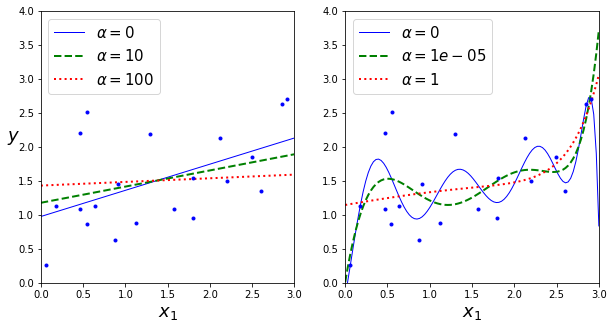

In [2]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else sklearn.linear_model.LinearRegression()
        if polynomial:
            model = sklearn.pipeline.Pipeline((
                    ("poly_features", sklearn.preprocessing.PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", sklearn.preprocessing.StandardScaler()),
                    ("regul_reg", model),
                ))
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(10,5))
plt.subplot(121)
plot_model(sklearn.linear_model.Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(sklearn.linear_model.Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)
plt.show()

对线性回归来说，对于岭回归，我们可以使用封闭方程去计算，也可以使用梯度下降去处理。它们的缺点和优点是一样的。`公式4-9`表示封闭方程的解(矩阵$\mathbf{A}$是一个除了左上角有一个0的$n \times n$的单位矩阵，这个0代表偏差项，偏差$\theta_0$不被正则化的)。
+ $\hat{\theta} = ({\mathbf{X}}^T\cdot\mathbf{X}+\alpha\mathbf{A})^{-1}\cdot{\mathbf{X}}^T\cdot\mathbf{y}$

下面是如何使用`Scikit-Learn`来进行封闭方程的求解(使用`Cholesky法`进行矩阵分解对`公式4-9`进行变形）:

In [3]:
ridge_reg = sklearn.linear_model.Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

使用随机梯度法进行求解：

In [4]:
sgd_reg = sklearn.linear_model.SGDRegressor(max_iter=5, penalty="l2")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

/home/alex/3rd/py-venv/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


array([1.12795912])

penalty参数指的是正则项的惩罚类型。指定`l2`表明你要在损失函数上添加一项：权重向量$\ell_2$范数平方的一半，这就是简单的岭回归。

### 4.5.2 Lasso回归
`Lasso回归`(也称`Least Absolute Shrinkage`，或者`Selection Operator Regression`)是另一种正则化版的线性回归：就像岭回归那样，它也在损失函数上添加了一个正则化项，但是它使用权重向量的$\ell_1$范数而不是权重向量$\ell_2$范数平方的一半(如`公式4-10`)：
+ $J(\theta)=MSE(\theta)+\alpha\sum\limits_{i=1}^n\left|\theta_i \right|$

`图4-18`展示了和`图4-17`相同的事情，仅仅是用Lasso模型代替了Ridge模型，同时调小了$\alpha$的值：

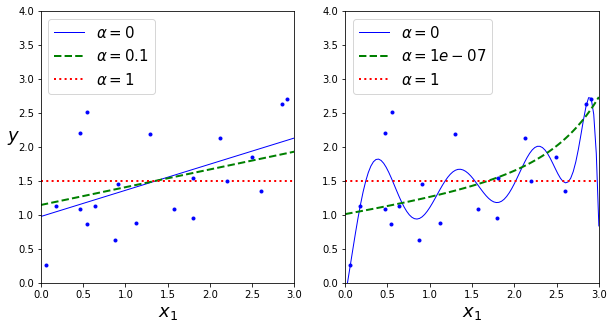

In [5]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plot_model(sklearn.linear_model.Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(sklearn.linear_model.Lasso, polynomial=True, alphas=(0, 10**-7, 1), tol=1, random_state=42)
plt.show()

Lasso回归的一个重要特征是它倾向于完全消除最不重要的特征的权重(即将它们设置为零)。例如，右图中的虚线所示($\alpha=10^{-7}$)，曲线看起来像一条二次曲线，而且几乎是线性的，这是因为所有的高阶多项特征都被设置为零。换句话说，Lasso回归自动的进行特征选择同时输出一个稀疏模型(即，具有很少的非零权重)。

你可以从`图4-19`知道为什么会出现这种情况：在左上角图中，后背景的等高线(椭圆)表示了没有正则化的均方差损失函数($\alpha=0$)，白色的小圆圈表示在当前损失函数上批量梯度下降的路径。前背景的等高线(菱形)表示$\ell_1$惩罚，黄色的三角形表示了仅在这个惩罚下批量梯度下降的路径($\alpha\rightarrow\infty$)。注意路径第一次是如何到达$\theta_1=0$，然后向下滚动直到它到达$\theta_2=0$。在右上角图中，等高线表示的是相同损失函数再加上一个$\alpha=0.5$的$\ell_1$惩罚。这幅图中，它的全局最小值在$\theta_2=0$这根轴上。批量梯度下降首先到达$\theta_2=0$，然后向下滚动直到达到全局最小值。 两个底部图显示了相同的情况，只是使用了$\ell_2$惩罚。 规则化的最小值比非规范化的最小值更接近于$\theta=0$，但权重不能完全消除。

<img src="images/04_19.png" style="width:600px;"/>

> **提示**
> 
> 在Lasso损失函数中，批量梯度下降的路径趋向与在低谷有一个反弹。这是因为在$\theta_2=0$时斜率会有一个突变。为了最后真正收敛到全局最小值，你需要逐渐的降低学习率

Lasso损失函数在$\theta_i=0 (i=1,2,\cdots,n)$处无法进行微分运算，但是使用梯度下降时，如果你使用子梯度向量$\mathbf{g}$后它可以在任何$\theta_i=0$的情况下进行计算。`公式4-11`是在Lasso损失函数上进行梯度下降的子梯度向量公式：
+ $g(\theta,J)=\nabla_{\theta}MSE(\theta)+ \alpha{\left(\begin{matrix} sign(\theta_1) \\ sign(\theta_2) \\ \vdots \\ sign(\theta_n) \\ \end{matrix}\right)}\ where\ sign(\theta_i)= \begin{cases} -1, &\theta_i<0 \\ 0, &\theta_i=0 \\ +1,&\theta_i>0 \\ \end{cases}$

下面是一个使用`Scikit-Learn`的Lasso类的小例子。你也可以使用`SGDRegressor(penalty="l1")`来代替它：

In [6]:
lasso_reg = sklearn.linear_model.Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

### 4.5.3 弹性网络(ElasticNet)
弹性网络介于Ridge回归和Lasso回归之间。它的正则项是Ridge回归和Lasso回归正则项的简单混合，同时你可以控制它们的混合率$r$，当$r=0$时，弹性网络就是Ridge回归，当$r=1$时，其就是Lasso回归。具体表示如`公式4-12`：
+ $J(\theta)=MSE(\theta)+r\alpha\sum\limits_{i=1}^n\left|\theta_i \right|+\frac{1-r}{2}\alpha\sum\limits_{i=1}^n\theta_i^2$

那么我们该如何选择线性回归、岭回归、Lasso回归、弹性网络呢？一般来说有一点正则项的表现更好，因此通常你应该避免使用简单的线性回归。岭回归是一个很好的首选项，但是如果你的特征仅有少数是真正有用的，你应该选择Lasso和弹性网络。就像我们讨论的那样，它两能够将无用特征的权重降为零。一般来说，弹性网络的表现要比Lasso好，因为当特征数量比样本的数量大的时候，或者特征之间有很强的相关性时，Lasso可能会表现的不规律。

下面是一个使用`Scikit-Learn`的`ElasticNet`(`l1_ratio`指的就是混合率$r$)的简单样例：

In [7]:
elastic_net = sklearn.linear_model.ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

### 4.5.4 早期停止法(Early Stopping)
对于迭代学习算法，有一种非常特殊的正则化方法，就像梯度下降在验证错误达到最小值时立即停止训练那样。我们称为`早期停止法`。`图4-20`表示使用批量梯度下降来训练一个非常复杂的模型(一个高阶多项式回归模型)。随着训练的进行，算法一直学习，它在训练集上的预测误差(RMSE)自然而然的下降。然而一段时间后，验证误差停止下降，并开始上升。这意味着模型在训练集上开始出现`过拟合`。一旦验证错误达到最小值，便提早停止训练。这种简单有效的正则化方法被`Geoffrey Hinton`称为`完美的免费午餐`：

<img src="images/04_20.png" style="width:500px;"/>

> **提示**
> 
> 随机梯度和小批量梯度下降不是平滑曲线，你可能很难知道它是否达到最小值。 一种解决方案是，只有在验证误差高于最小值一段时间后(你确信该模型不会变得更好了)，才停止，之后将模型参数回滚到验证误差最小值

下面是一个早期停止法的基础应用：

```python
from sklearn.base import clone
sgd_reg = SGDRegressor(n_iter=1, warm_start=True, penalty=None,learning_rate="constant", eta0=0.0005)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val_predict, y_val)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)
```

> **注意**
> 
> 当`warm_start=True`时，调用`fit()`方法后，训练会从停下来的地方继续，而不是从头重新开始